# Training feature selection

## Description

...


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import json
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import numpy as np
import pandas as pd
from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings  # Import the warnings module

import matplotlib.colors as mcolors

from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load training data and label dictionary

We will load the training data saved from the [feature extracion notebook](3_Training_feature_extraction.ipynb), along with the mapping between crop labels and the numerical classes.

In [2]:
# === Paths and filenames ===
base_path0 = 'Data'
data_info_name = 'parcels_static_info'

base_path = 'InputModel'
dataset_name = 'SB25r'
dataset_suffix = '_n0.2_process_filt'
# dataset_name = 'SB25r'
# dataset_suffix = '_n0.2_process_filt_merged_S24_GS20'

# === File locations ===
output_file0 = os.path.join(base_path0, f'{data_info_name}.csv')
output_file = os.path.join(base_path, f'{dataset_name}{dataset_suffix}.csv')

# === Load datasets ===
df0 = pd.read_csv(output_file0)
df = pd.read_csv(output_file)

# === Drop 'fid' column from df0 if it exists ===
if 'fid' in df0.columns:
    df0 = df0.drop(columns=['fid'])

# === Merge on FIELDID ===
df_merged = df.merge(df0, on='FIELDID', how='left')

df_merged_nan = df_merged.dropna()

# print column names
print(df_merged.columns)
print(f"Original Data shape: {df.shape}")
print(f"New Data shape: {df_merged.shape}")
print(f"New Data shape no NaN: {df_merged_nan.shape}")

Index(['FIELDID', 'Crop_type', 'Crop_num', 'area_ha', 'Year', 'week',
       'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec',
       'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 's1_vh',
       's1_vv', 's1_angle', 's1_sigma_vh_linear', 's1_sigma_vv_linear',
       's1_p_ratio', 's1_rvi', 's1_rcspr', 'Irrigation', 'week_sin',
       'week_cos', 'growth_rate_ndvi', 'growth_rate_evi', 'growth_r

In [3]:
# === Save merged dataset ===
# output_merged_file = os.path.join(base_path, f'{dataset_name}{dataset_suffix}_merged.csv')
# df_merged.to_csv(output_merged_file, index=False)

In [4]:
df = df_merged_nan.copy()

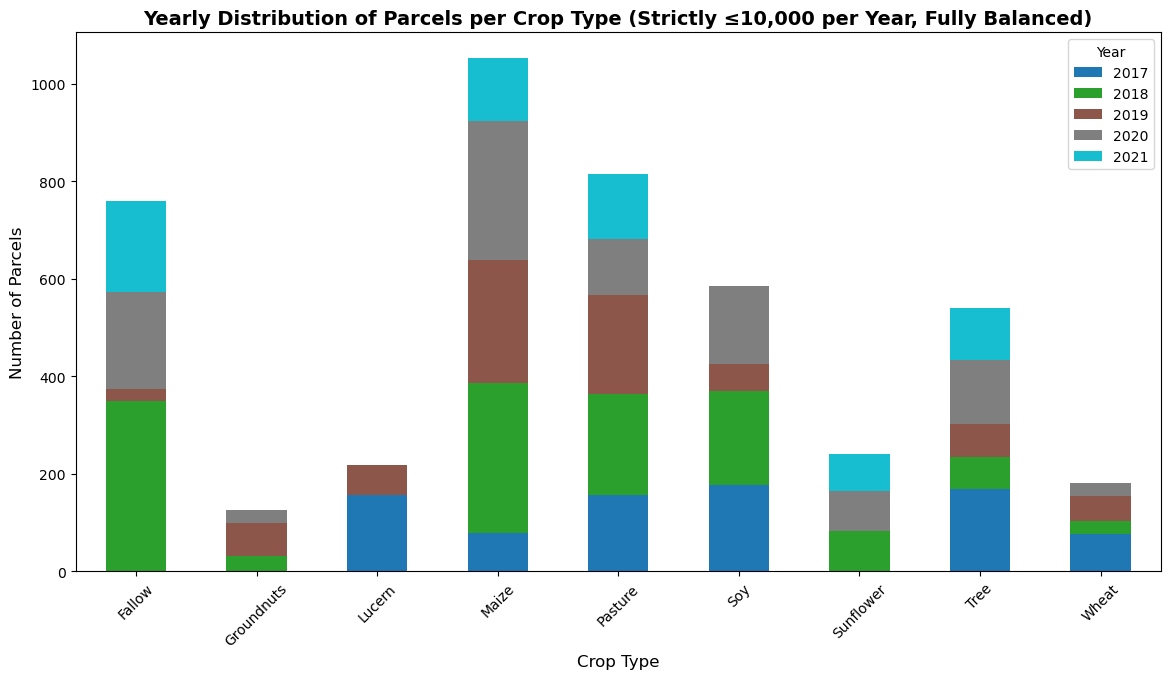

In [5]:
# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='Crop_type'>

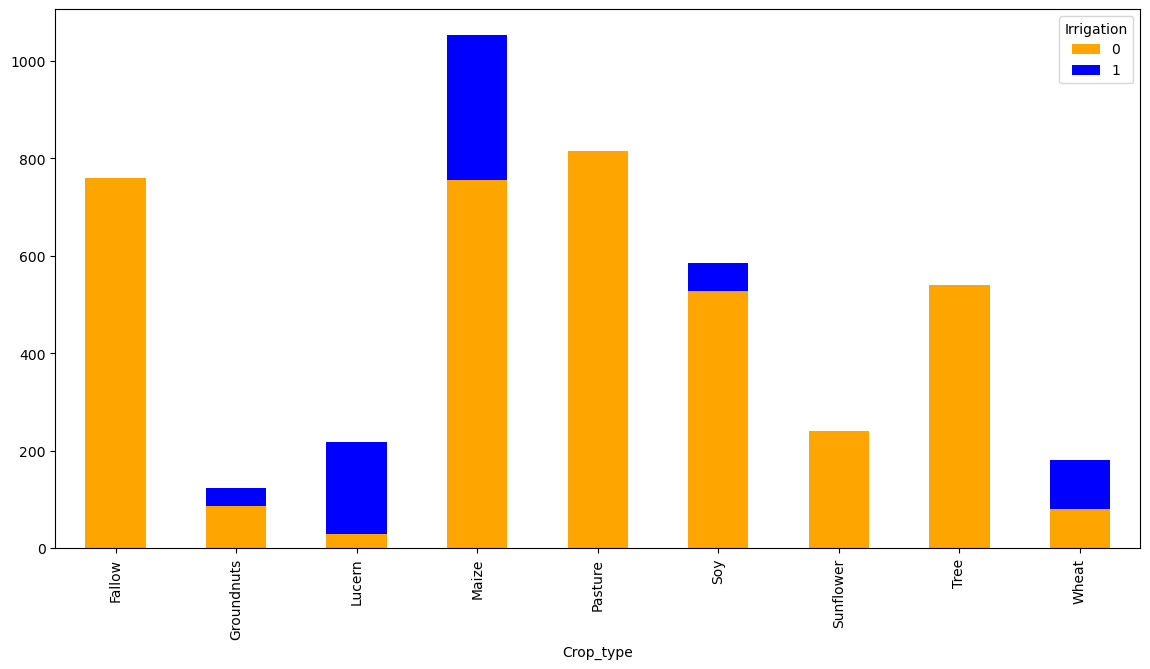

In [6]:
# plot histogram of Irrigation by Crop_type
df.groupby(['Crop_type', 'Irrigation']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['orange', 'blue'],  # 0 = orange (Rainfed), 1 = blue (Irrigated)
    figsize=(14, 7)
)

In [7]:
# Save df_limited to a new CSV file
out_path = 'InputModel'
# Save both df1 and df1_balanced to CSV files
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [8]:
# SB{min_valid_weeks}r
output_filename = os.path.join(out_path, f'{dataset_name}{dataset_suffix}_ecotope.csv')
# save df2_balanced to a new CSV file
df.to_csv(output_filename, index=False)

Restoring geometry column in df...


Text(105.34722222222221, 0.5, 'Latitude')

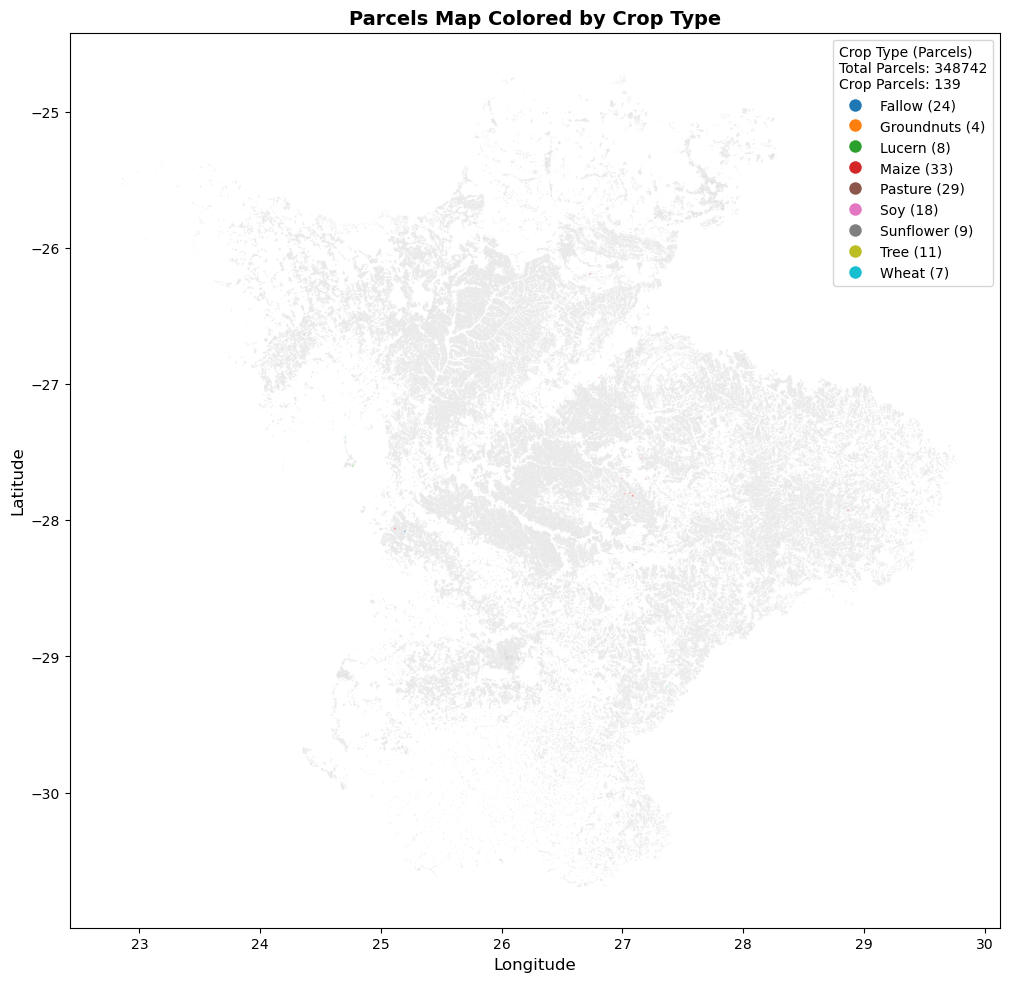

In [9]:
df_map = df.copy()

# Merge both datasets (all parcels)
gdf_fs = gpd.read_file(os.path.join("Data/geo/parcels", "FS.geojson"))
gdf_nw = gpd.read_file(os.path.join("Data/geo/parcels", "NW.geojson"))

# Ensure both datasets have a geometry column
if "geometry" not in gdf_fs.columns or "geometry" not in gdf_nw.columns:
    raise ValueError("One of the datasets is missing a geometry column.")

# Merge into gdf_total (all parcels)
gdf_total = pd.concat([gdf_fs, gdf_nw], axis=0, ignore_index=True)

# Ensure 'geometry' exists and is valid
if "geometry" not in gdf_total.columns:
    raise ValueError("gdf_total is missing the geometry column after merging.")

# Drop rows with missing geometry
gdf_total = gdf_total.dropna(subset=['geometry'])
gdf_total = gpd.GeoDataFrame(gdf_total, geometry='geometry', crs=gdf_fs.crs)

# Count total unique parcels
total_parcels = gdf_total['FIELDID'].nunique()

# **Fix missing geometry in df**
if "geometry" not in df_map.columns:
    print("Restoring geometry column in df...")
    df_map = df_map.merge(gdf_total[['FIELDID', 'geometry']], on='FIELDID', how='left')

# Ensure geometry exists before proceeding
df_map = df_map.dropna(subset=['geometry'])  # Remove rows where geometry is missing
gdf_crop = gpd.GeoDataFrame(df_map, geometry='geometry', crs=gdf_fs.crs)

# Ensure Crop_type column exists before proceeding
if "Crop_type" not in gdf_crop.columns:
    raise ValueError("The dataframe df is missing the 'Crop_type' column.")

# Count unique FIELDID values per Crop_type
crop_counts = gdf_crop.groupby('Crop_type')['FIELDID'].nunique().to_dict()  # Count unique parcels

# Count unique parcels in gdf_crop
crop_parcels = gdf_crop['FIELDID'].nunique()

# Define distinct colors for each crop type
colors = plt.cm.get_cmap('tab10', len(crop_counts))  # Use 'tab10' for distinct colors
crop_color_map = {crop: colors(i) for i, crop in enumerate(crop_counts.keys())}

# Plot the map
fig, ax = plt.subplots(figsize=(12, 12))

# Plot total parcels as a soft gray background
gdf_total.plot(ax=ax, color='lightgray', edgecolor='none', alpha=0.5)

# Overlay parcels colored by crop type
gdf_crop.plot(ax=ax, color=gdf_crop['Crop_type'].map(crop_color_map), edgecolor='white', linewidth=0.3, alpha=0.8)

# Create a legend with crop type and unique parcel count
legend_labels = [f"{c} ({crop_counts[c]})" for c in crop_counts.keys()]
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=crop_color_map[c], markersize=10)
    for c in crop_counts.keys()
]

# Update legend title to include both total and crop parcel counts
legend_title = f"Crop Type (Parcels)\nTotal Parcels: {total_parcels}\nCrop Parcels: {crop_parcels}"

ax.legend(handles, legend_labels, title=legend_title, loc='upper right')

# Improve title and axis labels
ax.set_title("Parcels Map Colored by Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)